In [1]:
import pickle
import subprocess
import os
import sys

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import xarray as xr

from pycdoexpr import cdoexpr


## 1. Generate Tabular Data

In [2]:
numbers = 3000
std = 2
data = (100*np.random.random(numbers)).astype(int)
label = data**2+np.sign(np.random.random(numbers) - 0.5)*std*np.random.random(numbers)
df = pd.DataFrame({'x':data, 'y':label})
df['x2'] = df['x']**2
train_X, test_X, train_y, test_y = train_test_split(df[['x','x2']], df['y'],
                      test_size = 0.3, random_state = 123)
df[['x', 'x2', 'y']]

,x,x2,y
0,24,576,577.254764
1,58,3364,3363.026159
2,33,1089,1088.811888
3,40,1600,1600.484216
4,80,6400,6401.753342
...,...,...,...
2995,94,8836,8836.374103
2996,14,196,195.814676
2997,69,4761,4760.803047
2998,59,3481,3480.895665


## 2. Train with XGBRegressor

In [3]:
model = XGBRegressor(n_estimators=30, max_depth=5, eta=0.1)
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [4]:
eval_df = pd.DataFrame({'predict':model.predict(test_X), 'label':test_y})
eval_df

,predict,label
1690,5680.811523,5930.738248
1798,2487.634766,2600.121517
417,9260.208008,9802.111714
1599,45.400089,47.971651
1206,8.728511,0.679747
...,...,...
1253,6266.856445,6562.886114
2135,2889.613770,3025.452967
2278,1041.927734,1088.507665
2876,9166.683594,9603.485690


In [5]:
pickle.dump(model, open('../static/test.pkl','wb'))

## 3. Generate 2 dimensional netCDF4 file 

In [6]:
shape = (20,20)
numbers = np.product(shape)
std = 4
data = (100*np.random.random(numbers)).astype(int)
data2 = data**2
label = data**2+np.sign(np.random.random(numbers) - 0.5)*std*np.random.random(numbers)

In [8]:
lon = np.arange(100,120,1)
lat = np.arange(20,40,1)
lon,lat = np.meshgrid(lon,lat)

input_ds = xr.Dataset(
    data_vars=dict(
        x=(['xlon','xlat'], data.reshape(shape)),
        x2=(['xlon', 'xlat'], data2.reshape(shape)),
    ),
    coords=dict(
        lon=(['xlon','xlat'], lon),
        lat=(['xlon','xlat'], lat),
    )
)
input_ds.to_netcdf('../static/test_input.nc')

label_ds = xr.Dataset(
    data_vars=dict(
        label=(['xlon','xlat'], label.reshape(shape)),
    ),
    coords=dict(
        lon=(['xlon','xlat'], lon),
        lat=(['xlon','xlat'], lat),
    )
)
label_ds.to_netcdf('../static/test_label.nc')

## 4. Model predict with pycdoexpr and cdo command

In [9]:
cexpr = cdoexpr()
expr = cexpr.xgb_decision_trees('../static/test.pkl', 'boosting')
cmd = f"cdo -f nc4 -expr,'{expr}' ../static/test_input.nc ../static/test_output.nc"
subprocess.check_call(cmd, shell=True)

Warning (cdfInqContents): Coordinates variable lon can't be assigned!
Warning (cdfInqContents): Coordinates variable lat can't be assigned!
Warning (cdfInqContents): Coordinates variable lon can't be assigned!
Warning (cdfInqContents): Coordinates variable lat can't be assigned!
cdo    expr: Processed 2 variables over 1 timestep [0.06s 14MB].


0

In [12]:
ds = xr.open_dataset('../static/test_output.nc')
label = xr.open_dataset('../static/test_label.nc')

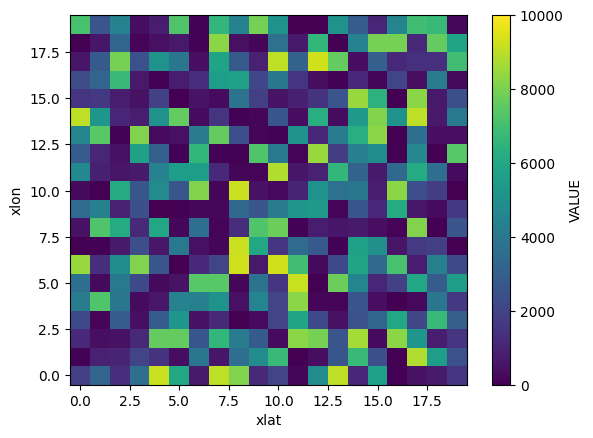

In [13]:
ds['VALUE'].plot(vmin=0,vmax=10000)

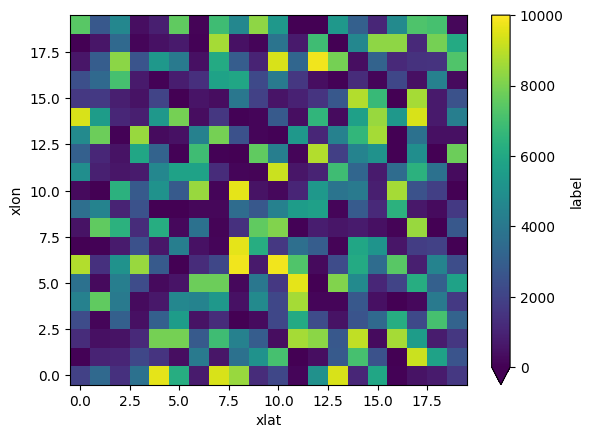

In [14]:
label['label'].plot(vmin=0,vmax=10000)

In [22]:
np.sqrt(((label['label'] - ds['VALUE'])**2).mean())

<xarray.DataArray ()>
array(189.63122398)